In [4]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hashlib

%matplotlib inline

In [5]:
path_train_data = r"./data/sales_train_v2.csv"
path_test_data = r"./data/test.csv"
path_sample_submission = r'./data/sample_submission.csv'
path_items = r"./info/items.csv"
path_shops = r"./info/shops.csv"
path_item_categories = r"./info/item_categories.csv"

In [6]:
schema_train = {
    "date":str,
    "date_block_num": 'category',
    "shop_id": 'category',
    "item_id": 'category',
    "item_price": float,
    "item_cnt_day": float
}

schema_test = {
    "ID": str,
    "shop_id": 'category',
    "item_id": 'category',
    "item_cnt_day": float
}

schema_test = {
    "ID": str,
    "item_cnt_moth": float
}

schema_items = {
    "item_name": str,
    "item_id": str,
    "item_category_id": 'category'
}

schema_shops = {
    "shop_name": str,
    "shop_id": str
}

schema_item_categories = {
    "item_category_name": str,
    "item_category_id": str
}

In [7]:
df_raw = pd.read_csv(path_train_data, dtype=schema_train)
df_raw['date'] = pd.to_datetime(df_raw['date'], format='%d.%m.%Y')

df_test = pd.read_csv(path_test_data, dtype=schema_test)
df_items = pd.read_csv(path_items, dtype=schema_items)
df_shops = pd.read_csv(path_shops, dtype=schema_shops)
df_item_cat = pd.read_csv(path_item_categories, dtype=schema_item_categories)


In [8]:
# Clip to [0, 20]
def clip_cnt(number):
    if number<0:
        return 0
    elif number > 20:
        return 20
    else:
        return number

In [9]:
df_items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [10]:
df_shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [11]:
df_item_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
ID         214200 non-null object
shop_id    214200 non-null int64
item_id    214200 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.9+ MB


In [13]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    category
shop_id           category
item_id           category
item_price        float64
item_cnt_day      float64
dtypes: category(3), datetime64[ns](1), float64(2)
memory usage: 79.2 MB


## Copy train set

In [14]:
df_train = df_raw.copy()

In [15]:
# Drop duplicates
df_train.drop_duplicates(inplace=True)

In [16]:
# Build a hash key for each row - takes some time to run
df_train['hashkey'] = df_train.apply(lambda x: hash(tuple(x)), axis = 1)

In [17]:
df_train['hashkey'] = df_train['hashkey'].astype(str)

In [18]:
# Set the hsh key as index
df_train.set_index('hashkey', inplace=True)

In [19]:
# Create month and year features to make our life easier.
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month
hashkey,,,,,,,,
8073002747745563977,2013-01-02,0,59,22154,999.00,1.0,2013,1
-4767116425902503097,2013-01-03,0,25,2552,899.00,1.0,2013,1
-5752843771445753871,2013-01-05,0,25,2552,899.00,-1.0,2013,1
-1228398442169262449,2013-01-06,0,25,2554,1709.05,1.0,2013,1
3856440396094777339,2013-01-15,0,25,2555,1099.00,1.0,2013,1


In [20]:
# save the hashed train table for future use
df_train.to_csv('./data/sales_train_v2_withhash.csv', index=True, encoding='utf-8')

## Explore data

Let's keep it simple and forget about all other information - imagine we only have the date and number of items, and nothing else. How will we make prediction?

One of the most obvious and standard model would be ARIMA. So let's try.

In [21]:
# Select only columns we need
df_train = df_train[['date', 'shop_id', 'item_id', 'item_cnt_day']]

In [22]:
# For exploration, plot the total daily sale autocorrelation using Pandas
df_agg_monthly = df_train.groupby('date').agg({'item_cnt_day': sum})
df_agg_monthly.rename({'item_cnt_day': 'item_cnt_month'}, inplace=True)

In [23]:
df_agg_monthly.head()

,item_cnt_day
date,
2013-01-01,1951.0
2013-01-02,8198.0
2013-01-03,7422.0
2013-01-04,6617.0
2013-01-05,6345.0


/home/long/anaconda3/envs/bq_test/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.


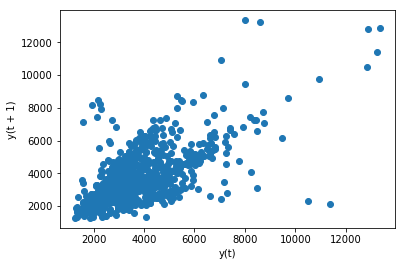

In [25]:
from pandas.tools.plotting import lag_plot, autocorrelation_plot

lag_plot(df_agg_monthly)

/home/long/anaconda3/envs/bq_test/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  if __name__ == '__main__':


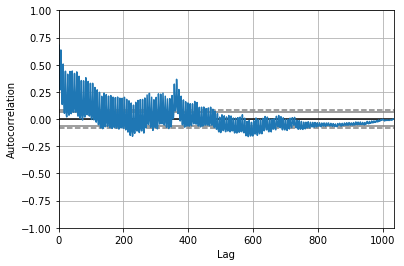

In [26]:
autocorrelation_plot(df_agg_monthly)